# Project: Wrangling and Analyze Data


## Table of Contents

<ul>
<li><a href="#questions">Questions for Analysis</a></li>
<li><a href="#gathering">Data Gathering/a></li>
<li><a href="#assessing">Assessing Data</a></li>
<li><a href="#cleaning">Cleaning Data</a></li>
<li><a href="#storing">Storing Data</a></li>
<li><a href="#visualizations">Analysing and Visualizing Data</a></li>
</ul>

In [109]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
from PIL import Image
from io import BytesIO

<a id='questions'></a>
### Questions for Analysis

Besides focusing in the Data Wrangling process, the present report is planned to answer the following questions during the analysis course:

1. Which dog stage tend to receive more likes?
2. Has the number of tweet retweets been increasing from year to year?
3. Proportion of tweet sources from the tweets.

<a id='gathering'></a>
## Data Gathering
For the first section, it will be gathered **all** three pieces of data for this project.

1. Directly downloading the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [110]:
archive_data = pd.read_csv('twitter-archive-enhanced.csv')

2. Using the Requests library to download the tweet image prediction (image_predictions.tsv)

In [111]:
try:
    # get the image dataset through the url
    url ='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
    images = requests.get(url)
    with open('./image-predictions.tsv', mode = 'w') as file:
        file.write(images.text)
except Exception as ex:
    print(ex)

* Reading images predictions dataset for further use:

In [112]:
images = pd.read_csv('image-predictions.tsv', sep ='\t')

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [114]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor

# Tweet IDs for which to gather additional data via Twitter's API
ids = archive_data.tweet_id.values
len(ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for id in ids:
        count += 1
        print(str(count) + ": " + str(id))
        try:
            tweet = api.get_status(id, tweet_mode = 'extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.errors.TweepError as ex:
            print("Failed")
            fails_dict[id] = ex
            pass
end = timer()
print(end - start)
print(fails_dict)


* For importing the data from the text file, and adding to the dataframe `additional_data`.

In [115]:
import json

add_dict = []

# Using the json file to gather the data
with open ('tweet_json.txt', 'r') as file:
    # get the number of tweets in the file
    count = len(file.readlines())
    file.seek(0, 0)
    try:
        # save the favorite and retweet count for each tweet id
        for i in range (count):
            line = file.readline()
            line = json.loads(line)
            id = line['id']
            favorites = line['favorite_count']
            retweets = line['retweet_count']
            # Adding the values in the dictionary
            add_dict.append({'tweet_id': id,
                 'favorites': favorites,
                 'retweets': retweets})
            # print(str(i) + ':'+ 'favorites:'+ str(favorites) +'; retweets: ' + str(retweets))
    except ValueError as e:
        print(str(i) + ':')
        print (e)

In [116]:
# Create DataFrame from list of dictionaries
additional = pd.DataFrame(add_dict, columns = ['tweet_id', 'favorites', 'retweets'])

In [117]:
additional.head()

,tweet_id,favorites,retweets
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514
2,891815181378084864,25461,4328
3,891689557279858688,42908,8964
4,891327558926688256,41048,9774


<a id='assessing'></a>
## Assessing Data
In this section, it will be detected and documented at least quality issues and tidiness issues. For this procedure, it was used both visual assessment and programmatic assessement to assess the data.

**Note:**  The assessment will be done taking into account the following key points:

* We only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.

#### Twitter Archive dataframe assessing

In [118]:
archive_data.shape

(2356, 17)

In [119]:
archive_data.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
163,860276583193509888,NaN,NaN,2017-05-04 23:34:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jordy. He likes to go on adventures an...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/860276583...,12,10,Jordy,None,None,None,None
1585,686947101016735744,NaN,NaN,2016-01-12 16:25:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jackson. He was specifically told not ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/686947101...,11,10,Jackson,None,None,None,None
1626,684800227459624960,NaN,NaN,2016-01-06 18:14:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Theodore. He's dapper as hell. Probably o...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684800227...,11,10,Theodore,None,None,None,None
407,823699002998870016,NaN,NaN,2017-01-24 01:08:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Winston. The goggles make him a superh...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/823699002...,12,10,Winston,None,None,None,None
1609,685547936038666240,NaN,NaN,2016-01-08 19:45:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Everybody needs to read this. Jack is our firs...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/685547936...,14,10,None,None,None,pupper,None


In [120]:
archive_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [121]:
archive_data.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [122]:
sum(archive_data.name.duplicated())

1399

In [123]:
archive_data.name.value_counts()

None         745
a             55
Charlie       12
Lucy          11
Cooper        11
Oliver        11
Lola          10
Tucker        10
Penny         10
Winston        9
Bo             9
Sadie          8
the            8
Daisy          7
Toby           7
Bailey         7
an             7
Buddy          7
Leo            6
Dave           6
Scout          6
Bella          6
Stanley        6
Milo           6
Koda           6
Jack           6
Rusty          6
Oscar          6
Jax            6
Sunny          5
            ... 
Randall        1
Iggy           1
Hazel          1
Ashleigh       1
Raphael        1
Farfle         1
Mojo           1
Kody           1
Remus          1
Dixie          1
Sonny          1
Ozzie          1
Cheryl         1
Sobe           1
Kara           1
Brandi         1
Evy            1
Hubertson      1
Ace            1
Mona           1
Roscoe         1
Nida           1
Murphy         1
Sailor         1
Mo             1
Jeffrie        1
Lucia          1
Rufio         

In [124]:
archive_data[archive_data.name == 'a'].sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2125,670361874861563904,NaN,NaN,2015-11-27 22:01:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Rich Mahogany Seltzer named Cherokee...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670361874...,9,10,a,None,None,None,None
2235,668171859951755264,NaN,NaN,2015-11-21 20:59:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Trans Siberian Kellogg named Alfonso...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668171859...,7,10,a,None,None,None,None
2198,668815180734689280,NaN,NaN,2015-11-23 15:35:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a wild Toblerone from Papua New Guinea...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668815180...,7,10,a,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
1193,717537687239008257,NaN,NaN,2016-04-06 02:21:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",People please. This is a Deadly Mediterranean ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/717537687...,11,10,a,None,None,None,None


In [125]:
archive_data.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [126]:
archive_data.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [127]:
archive_data[archive_data.in_reply_to_status_id > 0].sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1018,746818907684614144,6.914169e+17,4.196984e+09,2016-06-25 21:34:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Guys... Dog Jesus 2.0\n13/10 buoyant af https:...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/746818907...,13,10,None,None,None,None,None
1452,695767669421768709,6.753494e+17,4.196984e+09,2016-02-06 00:35:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",If you are aware of who is making these please...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/695767669...,13,10,None,None,None,None,None
1618,684969860808454144,6.849598e+17,4.196984e+09,2016-01-07 05:28:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...","For those who claim this is a goat, u are wron...",NaN,NaN,NaN,NaN,5,10,None,None,None,None,None
701,786051337297522688,7.727430e+17,7.305050e+17,2016-10-12 03:50:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",13/10 for breakdancing puppo @shibbnbot,NaN,NaN,NaN,NaN,13,10,None,None,None,None,puppo
570,801854953262350336,8.018543e+17,1.185634e+07,2016-11-24 18:28:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",.@NBCSports OMG THE TINY HAT I'M GOING TO HAVE...,NaN,NaN,NaN,NaN,11,10,None,None,None,None,None


#### Image dataframe assessing

In [128]:
images.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1406,770069151037685760,https://pbs.twimg.com/media/Cq_Vy9KWcAIUIuv.jpg,1,Boston_bull,0.414965,True,American_Staffordshire_terrier,0.286985,True,Staffordshire_bullterrier,0.114970,True
753,688179443353796608,https://pbs.twimg.com/media/CYznjAcUEAQ5Zq7.jpg,1,sorrel,0.811520,False,horse_cart,0.024820,False,Arabian_camel,0.015155,False
1291,751538714308972544,https://pbs.twimg.com/media/Cm4AeG8XEAAulD2.jpg,2,Labrador_retriever,0.516257,True,golden_retriever,0.210839,True,dingo,0.162022,False
803,691483041324204033,https://pbs.twimg.com/media/CZikKBIWYAA40Az.jpg,1,bloodhound,0.886232,True,black-and-tan_coonhound,0.077420,True,Gordon_setter,0.009826,True
1746,823269594223824897,https://pbs.twimg.com/media/C2kzTGxWEAEOpPL.jpg,1,Samoyed,0.585441,True,Pomeranian,0.193654,True,Arctic_fox,0.071648,False


In [129]:
images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [130]:
sum(images.duplicated())

0

#### Additional dataframe assessing

In [131]:
additional.sample(5)

,tweet_id,favorites,retweets
2172,669216679721873412,958,422
381,827228250799742977,0,13517
691,787111942498508800,0,7798
2212,668544745690562560,561,250
1857,675497103322386432,3397,1443


In [132]:
additional.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id     2354 non-null int64
favorites    2354 non-null int64
retweets     2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [133]:
sum(additional.duplicated())

0

### Quality issues

1. Retweet posts from WeRateDogs.

2. Retweet post related columns.

3. Dog stages mentioned but not noted.

4. `timestamp` attribute is object variable and `favorites` and `retweets` attributes are float variables.

5. Source attribute written as html tag.

6. Dogs named with 'a' have a real name in each the tweet.

7. Tweets with dog breed non-recognized.

8. Reply tweets without images.

9. Some dog breed names starting with lowercase letter. 

### Tidiness issues
1. Variable in four columns in `archive_data` table (doggo,	floofer, pupper, puppo).

2. Multiple variable values for dog breed (p1, p2, p3) in each row  in table `images`.

3. `additional` columns and  Dog breed column from `images` should be part of `archive_data` table.

<a id='cleaning'></a>
## Cleaning Data
In this section, it will be cleaned **all** of the issues you documented while assessing. 

In [134]:
# Making copies of original pieces of data
archive_data_clean = archive_data.copy()
images_clean = images.copy()
additional_clean = additional.copy()

### Missing values

#### 1. Dog stages mentioned but not noted

##### Define
For each dog stage column, fill its stage name in case the dog stage is mentioned in the tweet text. Verify if the all the dog stages columns are empty and start searching for for the dog stage using the text.

##### Code

In [135]:
# Mapping from full dog stage name to abbreviation
stages_abbrev = {'pupper': ['pups', 'pup', 'puppers', 'pupper', 'Pupper', 'puppears'],
                'puppo': ['puppo', 'Puppo', 'puppos'],
                'doggo': ['dog', 'doggo', 'Doggo', 'dogs'],
                'floofer': ['floof', 'floofer', 'Floofer' , 'fluffer', 'fluffy']}

# function to return the index of the dataset
count = -1
def getIndex():
    global count
    if (count == 2355):
        count = -1
    count += 1
    return count

# function to determine if the stages of the dog in the row are occupied or not
def NOccupied(ind):
    pupper = archive_data_clean.pupper.loc[ind]
    puppo = archive_data_clean.puppo.loc[ind]
    floofer = archive_data_clean.floofer.loc[ind]
    doggo = archive_data_clean.doggo.loc[ind]
    if (pupper == 'None') and (puppo == 'None') and (floofer == 'None') and (doggo == 'None'):
        return True
    else:
        return False

# function to read the tweet text return a dog stage in case it is found
def stages(ind, s):
    
    x = archive_data_clean.text.loc[ind]
    
    if NOccupied(ind):
        x = x.replace('.', ' ')
        x = x.split(' ')

        if (s == 'doggo'):
            for i in x:
                if i in stages_abbrev['doggo']:
                    return 'doggo'
        elif (s == 'pupper'):
            for i in x:
                if i in stages_abbrev['pupper']:
                    return 'pupper'
        elif (s == 'floofer'):
            for i in x:
                if i in stages_abbrev['floofer']:
                    return 'floofer'
        elif (s == 'puppo'):
            for i in x:
                if i in stages_abbrev['puppo']:
                    return 'puppo'
    else:
        pass

In [136]:

archive_data_clean = archive_data.copy()

archive_data_clean.pupper = archive_data_clean.pupper.apply(lambda x: x.replace('None', str(stages(getIndex(), 'pupper'))))
archive_data_clean.floofer = archive_data_clean.floofer.apply(lambda x: x.replace('None', str(stages(getIndex(), 'floofer'))))
archive_data_clean.doggo = archive_data_clean.doggo.apply(lambda x: x.replace('None', str(stages(getIndex(), 'doggo'))))
archive_data_clean.puppo = archive_data_clean.puppo.apply(lambda x: x.replace('None', str(stages(getIndex(), 'puppo'))))

##### Test

In [137]:
archive_data_clean.floofer.value_counts()

None       2322
floofer      34
Name: floofer, dtype: int64

In [138]:
archive_data_clean.pupper.value_counts()

None      1916
pupper     440
Name: pupper, dtype: int64

In [139]:
archive_data_clean.puppo.value_counts()

None     2325
puppo      31
Name: puppo, dtype: int64

In [140]:
archive_data_clean.doggo.value_counts()

None     1980
doggo     376
Name: doggo, dtype: int64

In [141]:
assert archive_data_clean.shape[0] == archive_data.shape[0]

#### 2. Some of the dogs named with 'a' have a real name in each the tweet

##### Define
Create a list with all the dogs' names and replace the 'a' names if they have a name contained in the text after 'named' word; if not, the 'a' name is replaced with 'None'.

##### Code

In [142]:
# Search for the name if dog's name is 'a'
data = archive_data_clean.name.values
for c, name in enumerate(data):
    if (name == 'a'):
        x = archive_data_clean.text.loc[c]
        x = x.replace('.', ' ')
        x = x.split(' ')
        for i, string in enumerate(x):
            if (string == 'named') and (x[i + 1][0].isupper()):
                data[c] = x[i + 1]
            else:
                data[c] = 'None'
    elif (name == 'the') or (name == 'an'):
        data[c] = 'None'

archive_data_clean = archive_data_clean.assign(name = data)

##### Test

In [143]:
archive_data_clean.name.value_counts().head(10)

None       815
Charlie     12
Lucy        11
Oliver      11
Cooper      11
Lola        10
Penny       10
Tucker      10
Bo           9
Winston      9
Name: name, dtype: int64

In [144]:
assert archive_data_clean.shape[0] == archive_data.shape[0]

#### 3. Tweets with dog breed non-recognized

##### Define
Get the dog breed values of `images` table (`p1_dog`, `p2_dog`, `p3_dog` columns)  and compare if the values of these columns are all False. If so, it will be dropped the column by its index, meaning that the dog breed was not recognized.

##### Code

In [145]:
img1 = images.p1_dog.values
img2 = images.p2_dog.values
img3 = images.p3_dog.values    
img_index = []
    
for i in range(len(images.index)):
    if (img1[i] == False) and (img2[i] == False) and (img3[i] == False):
        img_index.append(int(i))

images_clean.drop(img_index, axis = 0, inplace = True)
images_clean.sort_values('tweet_id', axis = 0, ascending = False, inplace = True)
images_clean.reset_index(inplace = True)
images_clean.drop(['index'], axis = 1, inplace = True)

##### Test

In [146]:
images_clean.query('p1_dog == False and p2_dog == False and p3_dog == False')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [147]:
images_clean.shape

(1751, 12)

#### 4. Reply tweets with missing images

##### Define
Get Reply tweet and images tweet_ids, and make a comparison to see if the reply tweet is contained in the images tweet_ids. If not, it means that the reply tweet was just a simple text conversation and will be dropped.

##### Code

In [148]:
# Get Reply tweet_ids
rp_list= []
ind = len(archive_data_clean.index)
for i in range(ind):
    row = archive_data_clean.loc[i]
    if (row.in_reply_to_status_id > 0):
        rp_list.append(row.tweet_id)

# Get images tweet_ids
img_list = []
ind = len(images_clean.index)
for i in range(ind):
    row = images_clean.loc[i]
    img_list.append(row.tweet_id)

# Compare if the reply tweets have images
drop_list = []
for i, id in enumerate(rp_list):
    count = 0
    for j in img_list:
        if (id != j):
            count += 1
        if (count == len(img_list)):
            drop_list.append(i)
            
# Drop the Reply tweets without images
archive_data_clean.drop(drop_list, axis = 0, inplace = True)
archive_data_clean.reset_index(inplace = True)
archive_data_clean.drop(['index'], axis = 1, inplace = True)

##### Test

In [149]:
archive_data_clean.shape

(2298, 17)

### Tidiness

#### 1. Variable in four columns of `archive_data` table (doggo, floofer, pupper, puppo)

##### Define

##### Define
Melt the `puppo`, `pupper`, `doggo` and `floofer` columns to a `dog_stage` column (the rows without a dog stage will be represented with 'None'). 

##### Code

In [150]:
# Create a copy of the clean dataframe to use the index further
archive_copy = archive_data_clean.copy()
# Melt dog stages columns
archive_data_clean = pd.melt(archive_data_clean, id_vars = ['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name'], value_vars = ['pupper', 'floofer', 'puppo', 'doggo'], var_name = ['dog_stage'])

# Get the values in the value column
values_list = archive_data_clean.value.values
# Make a loop in range of the original clean dataframe number of rows
for i in range(archive_copy.shape[0]):
    # Get the id of each row from the index
    id = archive_copy.tweet_id.loc[i]
    # Make a dataframe using the id. It will return 4 rows of each dog stage
    id_stages = archive_data_clean[archive_data_clean.tweet_id == id]
    count = 0
    for stage in id_stages.value.values:
        if (stage == 'None'):
            count += 1
            # If all the 4 rows have 'None' as value, the first row with the id will be 'None*',
            # so that the other rows can be deleted
            if (count == 4):
                values_list[i] = 'None*'

# Replace the values in the value column with the values_list created
archive_data_clean = archive_data_clean.assign(value = values_list)
archive_data_clean = archive_data_clean[archive_data_clean['value'] != 'None']
archive_data_clean.dog_stage = archive_data_clean.value.apply(lambda x: x.replace('None*', 'None'))
to_drop = archive_data_clean[archive_data_clean.tweet_id.duplicated()].index
archive_data_clean.drop(to_drop, axis = 0, inplace = True)
archive_data_clean.drop('value', axis = 1, inplace = True)
archive_data_clean.sort_values('tweet_id', axis = 0, ascending = False, inplace = True)
archive_data_clean.reset_index(inplace = True)
archive_data_clean.drop(['index'], axis = 1, inplace = True)

##### Test

In [151]:
archive_data_clean.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None
1,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,doggo
2,889531135344209921,NaN,NaN,2017-07-24 17:02:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stuart. He's sporting his favorite fan...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889531135...,13,10,Stuart,puppo


In [152]:
assert archive_data_clean.shape[0] == archive_copy.shape[0]

#### 2. Multiple variable values for dog breed (p1, p2, p3) in each row  in table `images`

##### Define
Make a list of the most confident dog breed for each row in the `images` table and create a new column `dog_breed` containing the results.

##### Code

In [153]:
# Get image rows index
breed_list= []
ind = len(images_clean.index)
# Loop for each row
for i in range(ind):
    row = images_clean.loc[i]
    if (row.p1_dog == True):
        breed_list.append(row.p1)
    elif (row.p2_dog == True):
        breed_list.append(row.p2)
    elif (row.p3_dog == True):
        breed_list.append(row.p3)
        
images_clean['dog_breed'] = breed_list
images_clean.drop(['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis = 1, inplace = True)

##### Test

In [154]:
images_clean.sample(5)

,tweet_id,jpg_url,img_num,dog_breed
671,755110668769038337,https://pbs.twimg.com/ext_tw_video_thumb/75511...,1,Labrador_retriever
1506,672068090318987265,https://pbs.twimg.com/media/CVOqW8eUkAESTHj.jpg,1,pug
1275,680070545539371008,https://pbs.twimg.com/media/CW-dU34WQAANBGy.jpg,1,Shih-Tzu
695,751251247299190784,https://pbs.twimg.com/ext_tw_video_thumb/75125...,1,Walker_hound
1747,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback


#### 3. `additional` columns and  `dog_breed` column from `images` should be part of `archive_data` table.

##### Define

Merge the clean `twitter_archive` dataset with the dataset containing the `dog_breed` data using left join based on the `tweet_id`. The `dog_breed` column will be dropped from `images` column after that procedure. Lastly, merge the clean `twitter_archive` dataset with the `additional` dataset using left join.

**Note:** After that procedure, the `additional` dataset will not be used further, once its data is in the cleaned `archive_data` dataset.

##### Code

In [155]:
dog_breeds = images_clean[['tweet_id','dog_breed']]
archive_data_clean = pd.merge(archive_data_clean, dog_breeds,
                            on=['tweet_id'], how = 'left') 
images_clean.drop(['dog_breed'], axis = 1, inplace = True)
archive_data_clean = pd.merge(archive_data_clean, additional_clean,
                            on=['tweet_id'], how = 'left')

##### Test

In [156]:
columns = pd.Series(list(archive_data_clean) + list(images_clean))
columns[columns.duplicated()]

17    tweet_id
dtype: object

In [157]:
assert archive_data_clean.shape[0] == archive_copy.shape[0]

### Quality

#### 1. Retweet posts from WeRateDogs

##### Define
Get the retweet posts index from the `archive_data_clean` and drop the rows.

##### Code

In [158]:
# Get Retweet rows index
rt_list= []
ind = len(archive_data_clean.index)
# Loop for each row
for i in range(ind):
    row = archive_data_clean.loc[i]
    if (row.retweeted_status_id > 0):
        rt_list.append(i)
    
archive_data_clean.drop(rt_list, axis = 0, inplace = True)

In [159]:
archive_data_clean.reset_index(inplace = True)
archive_data_clean.drop(['index'], axis = 1, inplace = True)
archive_data_clean.shape

(2122, 17)

##### Test

In [160]:
archive_data_clean[archive_data_clean.retweeted_status_id > 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,dog_breed,favorites,retweets


In [161]:
archive_data_clean.shape

(2122, 17)

#### 2. Retweet post related columns

##### Define
Drop the retweet posts related columns from the cleaned dataset.

##### Code

In [162]:
archive_data_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis = 1, inplace = True)

##### Test

In [163]:
archive_data_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stage', 'dog_breed', 'favorites',
       'retweets'],
      dtype='object')

#### 3. `timestamp` attribute is object variable and `favorites` and `retweets` attributes are float variables.

##### Define
Turn `timestamp` column into datetime format and turn `favorites` and `retweets` attributes into integer format.

##### Code

In [164]:
# For turning timestamp column into datetime format
from datetime import datetime
archive_data_clean.timestamp = archive_data_clean.timestamp.apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S +0000'))

# For turning favorites and retweets attributes into int format

archive_data_clean.favorites = archive_data_clean.favorites.astype('int64')
archive_data_clean.retweets = archive_data_clean.retweets.astype('int64')

##### Test

In [165]:
archive_data_clean.dtypes

tweet_id                          int64
in_reply_to_status_id           float64
in_reply_to_user_id             float64
timestamp                datetime64[ns]
source                           object
text                             object
expanded_urls                    object
rating_numerator                  int64
rating_denominator                int64
name                             object
dog_stage                        object
dog_breed                        object
favorites                         int64
retweets                          int64
dtype: object

#### 4. Source attribute written as html tag

##### Define
Clean the html tags from each source value by splitting the value and collecting the source address only.

##### Code

In [166]:
source_list= []
ind = len(archive_data_clean.index)
# Loop for each row
for i in range(ind):
    row = archive_data_clean.loc[i].source
    row = row.split('"')
    for c, source in enumerate(row):
        if (c == 1):
            source_list.append(source)
archive_data_clean.source = source_list

##### Test

In [167]:
archive_data_clean.source.head()

0    http://twitter.com/download/iphone
1    http://twitter.com/download/iphone
2    http://twitter.com/download/iphone
3    http://twitter.com/download/iphone
4    http://twitter.com/download/iphone
Name: source, dtype: object

#### 4. Some dog breed names starting with lowercase letter

##### Define
Get the first letter of the dog breed names and make it capitalized.

##### Code

In [168]:
archive_data_clean.dog_breed = archive_data_clean.dog_breed.str.capitalize()

##### Test

In [169]:
archive_data_clean.dog_breed.head()

0    Chesapeake_bay_retriever
1                  Pomeranian
2            Golden_retriever
3                   Chihuahua
4                         Pug
Name: dog_breed, dtype: object

<a id='storing'></a>
## Storing Data
Saving gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv", and saving tweet images cleaned dataset to a CSV file named "tweet_image_master.csv".

In [170]:
archive_data_clean.to_csv('twitter_archive_master.csv', index = False)

images_clean.to_csv('tweet_image_master.csv', index = False)

<a id='vizualising'></a>
## Analyzing and Visualizing Data

### 1. Which dog stage tend to receive more favorites?

#### Insights

* Histogram plot for Favorites count and Dog Stage distribution:

Median:  3903.0 
Mean:  8179.20405278


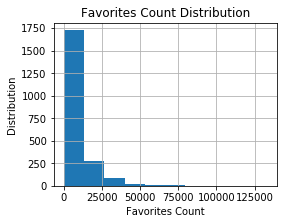

In [171]:
archive_data_clean['favorites'].hist(figsize = (4, 3))
plt.title('Favorites Count Distribution')
plt.xlabel('Favorites Count')
plt.ylabel('Distribution');
print('Median: ' , archive_data_clean['favorites'].median(), '\nMean: ' , archive_data_clean['favorites'].mean())

The plot shows that the distribution is skewed to the right, which means that most of the tweets tend to have less than 8 179 favorites and few of them more than 12 000 favorites.

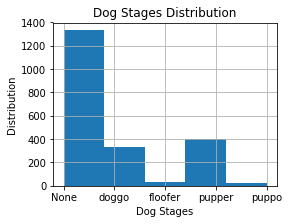

In [172]:
archive_data_clean['dog_stage'].hist(bins = 5, figsize = (4, 3));
plt.title('Dog Stages Distribution')
plt.xlabel('Dog Stages')
plt.ylabel('Distribution');

As it is shown above, most of the tweets in the archive does not mention the dogs stages, which is why the 'None' has the higher distribution number in relation to dogs stages. That being said, it will be worked further with the data that contains all the dog stages excepting those with 'None' as dog stage.

#### Visualization

Bar chart for each dog stage in terms of average favorite count:

Firstly, it will be filtered the data which dog stage is different from "None". After that. it will be calculated the medium favorite count for each dog stage and represented in the bar plt as follows. 

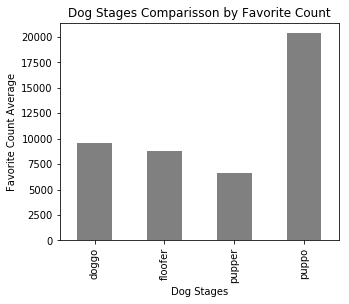

In [173]:
stages_df = archive_data_clean.query('dog_stage != "None"')
stages_df = stages_df.groupby(['dog_stage'])['favorites'].mean()
stages_df.plot(kind = 'bar', color = 'gray', figsize=(5, 4))
plt.title('Dog Stages Comparisson by Favorite Count')
plt.xlabel('Dog Stages')
plt.ylabel('Favorite Count Average');

The result cleary shows that 'puppo' is the most favorited dog stage of all dog stages mentioned in the tweets.

### 2. Has the number of tweet retweets been increasing from year to year?

Creating a copy of the cleaned dataset to gather the year of each tweet.

In [174]:
rt_df = archive_data_clean.copy()
rt_df['year'] = pd.DatetimeIndex(rt_df['timestamp']).year

#### Insights

* Histogram plot for Retweet count distribution:

Median:  1303.5 
Mean:  2660.38548539


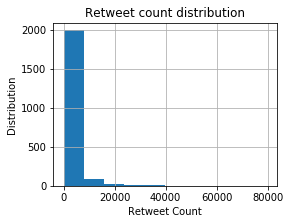

In [175]:
rt_df['retweets'].hist(bins = 10, figsize = (4, 3))
plt.title('Retweet count distribution')
plt.xlabel('Retweet Count')
plt.ylabel('Distribution');
print('Median: ' , rt_df['retweets'].median(), '\nMean: ' , rt_df['retweets'].mean())

The plot shows that the distribution of retweets is skewed to the right, which means that most of the tweets tend to have less than 2 660 retweets and few of them more than 10 000 favorites.

* Scatterplot of Tweet Year in relation to its Retweet count:

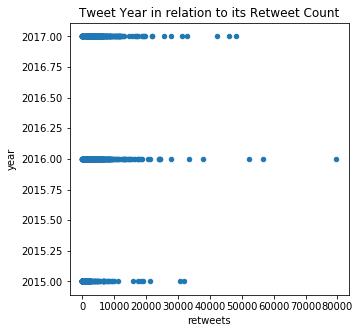

In [176]:
rt_df.plot(kind = 'scatter', x = 'retweets', y = 'year', figsize = (5, 5));
plt.title('Tweet Year in relation to its Retweet Count');

This data don't have any kind of pattern, which means that no relationship exists between the year of the tweet and the number of retweets.

#### Visualization

Bar chart for each year in terms of average retweet count:

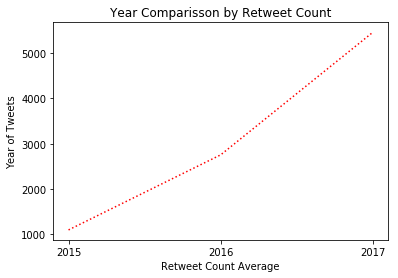

In [177]:
#rt_df.groupby(['year']).mean()['retweets'].plot( kind = 'barh', color = 'orange', figsize = (5, 3))
plt.plot(rt_df.groupby(['year']).mean()['retweets'], ls = ':', color = 'red')
plt.xticks([2015, 2016, 2017])
plt.title('Year Comparisson by Retweet Count')
plt.xlabel('Retweet Count Average')
plt.ylabel('Year of Tweets');

It is shown that the retweet count increased through the years, besides the lack of relation between the two variables.

### 3. Proportion of tweet sources from the tweets

For the question, it will be gathered the proportion of number of twitter source tweets and vine source tweets. These two are the only tweet sources contained in the given archive.

In [178]:
# Getting the number of twitter source tweets (numerator)
twitter_source = archive_data_clean.source.value_counts().loc[archive_data_clean.source.value_counts().index.str.contains('twitter')].values
twitter_source = twitter_source.sum()
# Getting the number of vine source tweets (numerator)
vine_source = archive_data_clean.source.value_counts().loc[archive_data_clean.source.value_counts().index.str.contains('vine')].values
vine_source = vine_source.sum()
# Number of all tweets with sources (denominator)
tweet_count = archive_data_clean.source.count()

print('Twitter source: ' , twitter_source, '\nVine source: ' , vine_source)

Twitter source:  2031 
Vine source:  91


Twitter source and Vine source number of tweets have collected. Now it can be easily shown the proportion of each source as follows:

In [179]:
# Percentage of twitter source tweets
twitter = twitter_source / tweet_count
# Percentage of vine source tweets
vine = vine_source / tweet_count

print('Percentage of twitter source tweets ' , twitter, '\nPercentage of vine source tweets: ' , vine)

Percentage of twitter source tweets  0.957115928369 
Percentage of vine source tweets:  0.0428840716305


Lastly, it will just be created a dataframe with the data acquired above, for visualization.

In [180]:
# Creating a dataframe for pie chart with each tweet source proportion
twitter_source = ['twitter'] * twitter_source
vine_source = ['vine'] * vine_source
sources = twitter_source + vine_source

source_df = []

for i in sources:
    source_df.append({'source': i})
    
source_df = pd.DataFrame(source_df)

#### Visualization

* Pie Chart for the tweet sources:

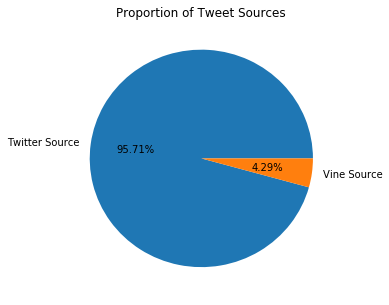

In [181]:
labels = np.full(len(source_df.source.value_counts()), "", dtype = object)
labels[0] = 'Twitter Source'
labels[1] = 'Vine Source'
source_plt = source_df.source.value_counts().plot(kind="pie", labels=labels, legend=False, autopct='%1.2f%%', figsize = (5, 5));
source_plt.set_ylabel('')
plt.title('Proportion of Tweet Sources');

As result, 95.71% of the tweets are from the Twitter itself, and just 4.29% are from Vine platform.